## Global vars/imports

In [34]:
base_dir='/tmp/cars'
model_dir=base_dir + '/model'
dataset_dir='https://workshopml.spock.cloud/datasets/cars'
pre_trained_model='https://workshopml.spock.cloud/models/cars/model.tar.gz'

In [2]:
# kernel conda_mxnet_p36

%matplotlib inline
import json
import logging
import os
import time
import numpy as np
import mxnet as mx
import sagemaker
import cv2
import pandas as pd
import tarfile
import inspect
import random
import boto3
import matplotlib.pyplot as plt

from sagemaker.mxnet import MXNet

from PIL import Image
from sagemaker.predictor import json_serializer, json_deserializer
from collections import namedtuple

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


In [3]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
print(mx.__version__)

0.12.1


## MxNet container functions

In [4]:
# Training method
def train(current_host, hosts, num_cpus, num_gpus, channel_input_dirs, model_dir, hyperparameters, **kwargs):
    
    # Helper class for keeping track of accuracy
    class EpochCheckpoint(object):
        def __init__(self):
            self.best_epoch_accuracy = 0.0
            self.best_epoch_id = -1

        def __call__(self, param): 
            if param.eval_metric is not None:
                name_value = param.eval_metric.get_name_value()
                epoch_accuracy = list(i[1] for i in name_value)[0]

                if epoch_accuracy > self.best_epoch_accuracy:
                    self.best_epoch_accuracy = epoch_accuracy
                    self.best_epoch_id = param.epoch+1
    
    print(hyperparameters)
    # retrieve the hyperparameters we set in notebook (with some defaults)
    batch_size = hyperparameters.get('batch_size', 128)
    epochs = hyperparameters.get('epochs', 100)
    learning_rate = hyperparameters.get('learning_rate', 0.00007)
    log_interval = hyperparameters.get('log_interval', 50)
    data_dir = channel_input_dirs['training']

    ctx = [mx.gpu(i) for i in range(num_gpus)] if num_gpus > 0 else [mx.cpu()]
    mx.random.seed(127)
    num_classes=196

    # Download a pre trained ImageNet 11k
    path='http://data.mxnet.io/models/imagenet-11k/'
    [mx.test_utils.download(path+'resnet-152/resnet-152-symbol.json', dirname=base_dir),
     mx.test_utils.download(path+'resnet-152/resnet-152-0000.params', dirname=base_dir),
     mx.test_utils.download(path+'synset.txt', dirname=base_dir)]   
    
    sym, arg_params, aux_params = mx.model.load_checkpoint(base_dir + '/resnet-152', 0)
    mod = mx.mod.Module(symbol=sym, context=ctx, label_names=None)
    mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))], 
             label_shapes=mod._label_shapes)
    mod.set_params(arg_params, aux_params, allow_missing=True)
    
    # slicing the trained resnet to create the Frankenstein
    all_layers = sym.get_internals()
    net = all_layers['flatten0_output']
    net = mx.symbol.Dropout(data=net, p=0.7, name='drop1')
    net = mx.symbol.FullyConnected(data=net, num_hidden=num_classes, name='fc1')
    net = mx.symbol.Dropout(data=net, p=0.2, name='drop1')
    net = mx.symbol.SVMOutput(data=net, name='svm')
    
    new_args = dict({k:arg_params[k] for k in arg_params if 'fc1' not in k})

    new_args['fc1_weight'] = mx.nd.zeros((num_classes,2048))
    new_args['fc1_bias'] = mx.nd.zeros((num_classes))

    w = arg_params['fc1_weight']
    b = arg_params['fc1_bias']
    
    # Load the new model
    deep_car_mod = mx.mod.Module(symbol=net, context=ctx, label_names=[ 'svm_label'])
    deep_car_mod.bind(for_training=True, data_shapes=[('data', (batch_size,3,224,224))], 
             label_shapes=[('svm_label', (batch_size,))])
    deep_car_mod.init_params(mx.initializer.Xavier(rnd_type="uniform", magnitude="2.34"))
    deep_car_mod.set_params(new_args, aux_params, allow_missing=False)
    
    train_data = get_train_data(data_dir, batch_size, (3, 224, 224))
    test_data = get_test_data(data_dir, batch_size, (3, 224, 224))

    model_filename_prefix = os.path.join(model_dir, 'cars_labels_model' )
    epoch_checkpoint = EpochCheckpoint()
    
    # train with the same
    deep_car_mod.fit(train_data,
        eval_data=test_data,
        optimizer='adam',
        optimizer_params={'learning_rate':learning_rate},
        eval_metric='acc',
        epoch_end_callback=mx.callback.do_checkpoint(model_filename_prefix),
        batch_end_callback=mx.callback.Speedometer(batch_size, log_interval),
        eval_end_callback=epoch_checkpoint,
        num_epoch=epochs,
        force_init=True)

    print("Best epoch id: %d - Accuracy: %f" % (epoch_checkpoint.best_epoch_id, epoch_checkpoint.best_epoch_accuracy ) )
    
    os.rename(model_filename_prefix + '-%04d.params' % epoch_checkpoint.best_epoch_id,
        model_filename_prefix + '-best.params' )

    return deep_car_mod

In [5]:
# Save the best accuracy model
def save(net, model_dir):
    # model_dir will be empty except on primary container
    files = os.listdir(model_dir)
    if files:
        for i in files:
            if i.endswith('params') and not i.endswith('best.params'):
                os.remove( os.path.join(model_dir, i) )
        os.rename( os.path.join(model_dir, 'cars_labels_model-best.params' ),
            os.path.join(model_dir, 'cars_labels_model-0000.params' ) )

In [6]:
# Return the test data iterator
def get_test_data(data_dir, batch_size, data_shape):
    return mx.image.ImageIter(
        batch_size=batch_size, 
        data_shape=data_shape,
        path_imglist=os.path.join(data_dir, 'cars_test.lst'),
        path_imgrec=os.path.join(data_dir, 'cars_test.rec') )


In [7]:
# Return the train data iterator
def get_train_data(data_dir, batch_size, data_shape):
    return mx.image.ImageIter(
        batch_size=batch_size, 
        data_shape=data_shape,
        path_imglist=os.path.join(data_dir, 'cars_train.lst'),
        path_imgrec=os.path.join(data_dir, 'cars_train.rec') )

In [8]:
# Validation method
def test(ctx, net, test_data):
    test_data.reset()
    metric = mx.metric.Accuracy()
    
    Batch = namedtuple('Batch', ['data'])
    
    outputs = []
    for i, batch in enumerate(test_data):
        label = batch.label
        for img in batch.data:
            net.forward(Batch([img]))
            outputs.append(net.get_outputs())
        metric.update(label, outputs)
     
    return metric.get()

In [9]:
# Load the saved model and return it
def model_fn(model_dir):
    """
    Load the model. Called once when hosting service starts.

    :param: model_dir The directory where model files are stored.
    :return: a model (in this case a network)
    """
    
    batch_size=1
    sym, arg_params, aux_params = mx.model.load_checkpoint(os.path.join(model_dir, 'cars_labels_model'), 0)
    deep_car_mod = mx.mod.Module(symbol=sym, context=mx.cpu(), label_names=[ 'svm_label'])
    deep_car_mod.bind(for_training=False, data_shapes=[('data', (batch_size,3,224,224))], label_shapes=deep_car_mod._label_shapes)
    deep_car_mod.set_params(arg_params, aux_params, allow_missing=False)

    return deep_car_mod

In [10]:
# Do the prediction and return the top-5 classes
def transform_fn(net, data, input_content_type, output_content_type):
    """
    Transform a request using the model. Called once per request.

    :param net: The model.
    :param data: The request payload.
    :param input_content_type: The request content type.
    :param output_content_type: The (desired) response content type.
    :return: response payload and content type.
    """
    resp = []
    try:
        # we can use content types to vary input/output handling, but
        # here we just assume json for both
        Batch = namedtuple('Batch', ['data'])

        parsed = json.loads(data)
        img = mx.nd.array(parsed)

        net.forward(Batch([mx.nd.array(img)]))
        prob = net.get_outputs()[0][0].asnumpy()

        # print the top-5
        prob = np.squeeze(prob)
        a = np.argsort(prob)[::-1]
        resp = []
        for i in a[0:5]:
            resp.append({"%d"%i: float(prob[i])})

    except Exception as e:
        logging.error(e)

    return json.dumps(resp), output_content_type

## Helper functions

In [11]:
# Encoder for converting numpy to json
class NumPyArangeEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist() # or map(int, obj)
        return json.JSONEncoder.default(self, obj)

In [12]:
def predict(val_iter, endpoint_name=None):
    batch = val_iter.next()
    img = batch.data[0].asnumpy()
    img_ = img[0].transpose((1,2,0))
    label_id = int(batch.label[0].asnumpy()[0])

    encode_param=[int(cv2.IMWRITE_JPEG_QUALITY),90]
    _,im=cv2.imencode('.jpg', img_, encode_param)
    im = cv2.imdecode(im,1)
    plt.imshow(im)
    print("Ground truth [%d] - %s\n" %( label_id, object_classes[label_id] ) )
    
    # Convert the image to a Json array
    data = json.dumps(img, cls=NumPyArangeEncoder)
    #print(data)
    if endpoint_name is None:
        # Call our model for predicting
        input_content_type = 'application/json'
        output_content_type = 'application/json'
        response = transform_fn(net, data, input_content_type, output_content_type)
        
    else:
        sm = boto3.client('sagemaker-runtime')
        response = sm.invoke_endpoint(
            EndpointName=endpoint_name,
            Body=data
        )
        response = [response['Body'].read().decode('utf-8')]

    for i in json.loads(response[0]):
        label_id = int(list(i)[0])
        print("Predicted [%d] - %s [%s]" % (label_id, object_classes[label_id], i[str(label_id)] ) )

## Testing our code locally

## Downloading the dataset

In [13]:
mx.test_utils.download(dataset_dir + '/cars_all_test.lst', fname="cars_test.lst", dirname=base_dir + '/data')
mx.test_utils.download(dataset_dir + '/cars_all_train.lst', fname="cars_train.lst", dirname=base_dir + '/data')
mx.test_utils.download(dataset_dir + '/cars_all_test.rec', fname="cars_test.rec", dirname=base_dir + '/data')
mx.test_utils.download(dataset_dir + '/cars_all_train.rec', fname="cars_train.rec", dirname=base_dir + '/data')
!ls -lat $base_dir/data

INFO:root:create directory /tmp/cars/data
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): workshopml.spock.cloud
DEBUG:urllib3.connectionpool:https://workshopml.spock.cloud:443 "GET /datasets/cars/cars_all_test.lst HTTP/1.1" 200 70287
INFO:root:downloaded https://workshopml.spock.cloud/datasets/cars/cars_all_test.lst into /tmp/cars/data/cars_test.lst successfully
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): workshopml.spock.cloud
DEBUG:urllib3.connectionpool:https://workshopml.spock.cloud:443 "GET /datasets/cars/cars_all_train.lst HTTP/1.1" 200 163865
INFO:root:downloaded https://workshopml.spock.cloud/datasets/cars/cars_all_train.lst into /tmp/cars/data/cars_train.lst successfully
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): workshopml.spock.cloud
DEBUG:urllib3.connectionpool:https://workshopml.spock.cloud:443 "GET /datasets/cars/cars_all_test.rec HTTP/1.1" 200 50903628
INFO:root:downloaded https://workshopml.spock.cloud/datasets/c

total 163220
-rw-rw-r-- 1 ec2-user ec2-user 115979576 Mar 26 23:40 cars_train.rec
drwxrwxr-x 2 ec2-user ec2-user      4096 Mar 26 23:40 .
-rw-rw-r-- 1 ec2-user ec2-user  50903628 Mar 26 23:40 cars_test.rec
-rw-rw-r-- 1 ec2-user ec2-user    163865 Mar 26 23:40 cars_train.lst
-rw-rw-r-- 1 ec2-user ec2-user     70287 Mar 26 23:40 cars_test.lst
drwxrwxr-x 3 ec2-user ec2-user      4096 Mar 26 23:40 ..


In [14]:
mx.test_utils.download(dataset_dir + '/dataset_classes.json', dirname=base_dir + '/data')

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): workshopml.spock.cloud
DEBUG:urllib3.connectionpool:https://workshopml.spock.cloud:443 "GET /datasets/cars/dataset_classes.json HTTP/1.1" 200 11446
INFO:root:downloaded https://workshopml.spock.cloud/datasets/cars/dataset_classes.json into /tmp/cars/data/dataset_classes.json successfully


'/tmp/cars/data/dataset_classes.json'

In [15]:
classes = json.loads(open(base_dir + '/data/dataset_classes.json', 'r').read())
class_map = {}
for l in classes['samples']:
    class_map[l['id']] = l['name']

object_classes = []
for i,k in enumerate(sorted(["%s" % (i+1) for i in range(196)])):
    object_classes.append(class_map[k] )

## Testing our code locally

In [16]:
# Some dummy variables for mocking sagemaker calls
current_host='algo-1'
hosts=['algo-1']
num_cpus=4
num_gpus=1
channel_input_dirs={
    'training': base_dir + '/data'
}
hyperparameters = {
    "learning_rate": 0.07,
    "batch_size": 32,
    "epochs": 1,
    "log_interval": 10
}

In [17]:
%%time
# Create our final model (it takes around)
!mkdir -p $model_dir
!rm -f $model_dir/*
# -> open the terminal and execute: watch nvidia-smi
net = train(current_host, hosts, num_cpus, num_gpus, channel_input_dirs, model_dir, hyperparameters)
logger.setLevel(logging.INFO)

DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): data.mxnet.io
DEBUG:urllib3.connectionpool:http://data.mxnet.io:80 "GET /models/imagenet-11k/resnet-152/resnet-152-symbol.json HTTP/1.1" 200 224147
INFO:root:downloaded http://data.mxnet.io/models/imagenet-11k/resnet-152/resnet-152-symbol.json into /tmp/cars/resnet-152-symbol.json successfully
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): data.mxnet.io
DEBUG:urllib3.connectionpool:http://data.mxnet.io:80 "GET /models/imagenet-11k/resnet-152/resnet-152-0000.params HTTP/1.1" 200 325133507


{'learning_rate': 0.07, 'batch_size': 32, 'epochs': 1, 'log_interval': 10}


INFO:root:downloaded http://data.mxnet.io/models/imagenet-11k/resnet-152/resnet-152-0000.params into /tmp/cars/resnet-152-0000.params successfully
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): data.mxnet.io
DEBUG:urllib3.connectionpool:http://data.mxnet.io:80 "GET /models/imagenet-11k/synset.txt HTTP/1.1" 200 None
INFO:root:downloaded http://data.mxnet.io/models/imagenet-11k/synset.txt into /tmp/cars/synset.txt successfully
INFO:root:Using 1 threads for decoding...
INFO:root:Set enviroment variable MXNET_CPU_WORKER_NTHREADS to a larger number to use more threads.
INFO:root:ImageIter: loading recordio /tmp/cars/data/cars_train.rec...
INFO:root:ImageIter: loading image list /tmp/cars/data/cars_train.lst...
INFO:root:Using 1 threads for decoding...
INFO:root:Set enviroment variable MXNET_CPU_WORKER_NTHREADS to a larger number to use more threads.
INFO:root:ImageIter: loading recordio /tmp/cars/data/cars_test.rec...
INFO:root:ImageIter: loading image list /tmp/cars/data/ca

Best epoch id: 1 - Accuracy: 0.013799
CPU times: user 6min 31s, sys: 1min 46s, total: 8min 17s
Wall time: 5min 55s


In [18]:
# Save the model
save(net, model_dir)
!ls -lat $model_dir

total 229580
drwxrwxr-x 2 ec2-user ec2-user      4096 Mar 26 23:48 .
-rw-rw-r-- 1 ec2-user ec2-user 234783699 Mar 26 23:46 cars_labels_model-0000.params
-rw-rw-r-- 1 ec2-user ec2-user    292684 Mar 26 23:46 cars_labels_model-symbol.json
drwxrwxr-x 4 ec2-user ec2-user      4096 Mar 26 23:41 ..


In [19]:
# Retrive the model
net = model_fn(model_dir)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['svm_label'])
  warnings.warn(msg)


In [20]:
# loads a test dataset for testing
val_iter = mx.image.ImageIter(
    batch_size=1, data_shape=(3, 224, 224), 
    path_imglist=base_dir + '/data/cars_test.lst',
    path_imgrec=base_dir + '/data/cars_test.rec')

INFO:root:Using 1 threads for decoding...
INFO:root:Set enviroment variable MXNET_CPU_WORKER_NTHREADS to a larger number to use more threads.
INFO:root:ImageIter: loading recordio /tmp/cars/data/cars_test.rec...
INFO:root:ImageIter: loading image list /tmp/cars/data/cars_test.lst...


Ground truth [170] - Chrysler Aspen SUV 2009

Predicted [0] - AM General Hummer SUV 2000 [-0.722750723361969]
Predicted [158] - Chevrolet Avalanche Crew Cab 2012 [-0.7565624713897705]
Predicted [23] - Audi RS 4 Convertible 2008 [-0.759672224521637]
Predicted [49] - Isuzu Ascender SUV 2008 [-0.7603846192359924]
Predicted [7] - Fisker Karma Sedan 2012 [-0.7638691067695618]


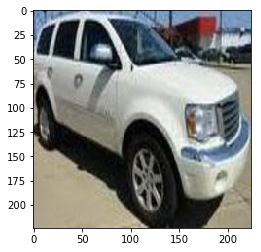

In [21]:
predict(val_iter)

### Now, let's download an 88% accuracy model and overwrite our previous model

In [35]:
!curl $pre_trained_model | tar -xz -C $model_dir

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  207M  100  207M    0     0  51.9M      0  0:00:04  0:00:04 --:--:-- 50.7M


In [23]:
# Retrive the model again
net = model_fn(model_dir)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['svm_label'])
  warnings.warn(msg)


Ground truth [19] - Ford E-Series Wagon Van 2012

Predicted [19] - Ford E-Series Wagon Van 2012 [1.1195260286331177]
Predicted [77] - Nissan NV Passenger Van 2012 [-1.0564117431640625]
Predicted [155] - Chevrolet Tahoe Hybrid SUV 2012 [-1.142269492149353]
Predicted [8] - Ford F-450 Super Duty Crew Cab 2012 [-1.215299367904663]
Predicted [16] - Ford F-150 Regular Cab 2012 [-1.2296146154403687]


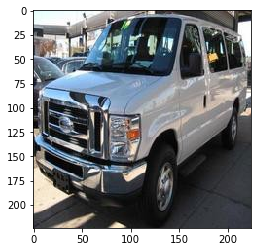

In [24]:
predict(val_iter)

## Saving the script

In [25]:
# Saving all the functions into a python script.
# It will be sent to a Sagemaker process
code = open(base_dir + '/cars.py', 'w')
code.write("""
import json
import logging
import os
import time
import numpy as np
import mxnet as mx

from collections import namedtuple

base_dir="."

""")
for obj in [train, save, get_test_data, get_train_data, test, model_fn, transform_fn]:
    code.write(inspect.getsource(obj) + '\n')
code.flush()
code.close()

## Training your model on Sagemaker (you can skip this session)

In [27]:
# Get the current Sagemaker session
sagemaker_session = sagemaker.Session()

role = sagemaker.get_execution_role()

INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): 169.254.169.254
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): 169.254.169.254
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): 169.254.169.254
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): 169.254.169.254
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): sts.amazonaws.com


In [28]:
inputs = sagemaker_session.upload_data(path=base_dir + '/data/', key_prefix='data/cars')
print('input spec (in this case, just an S3 path): {}'.format(inputs))

INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): sts.amazonaws.com
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): s3.amazonaws.com
INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-715445047862
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): s3.amazonaws.com


input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-715445047862/data/cars


In [29]:
m = MXNet(base_dir + '/cars.py', 
          role=role, 
          train_instance_count=1, 
          train_instance_type="ml.p3.2xlarge",
          hyperparameters={'batch_size': 32, 
                           'epochs': 2,
                           'learning_rate': 0.00007})

INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): 169.254.169.254
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): 169.254.169.254


In [30]:
m.fit(inputs)

INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): sts.amazonaws.com
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): s3.amazonaws.com
INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-715445047862
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): s3.amazonaws.com
INFO:sagemaker:Creating training-job with name: sagemaker-mxnet-py2-gpu-2018-03-26-23-50-42-522
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): sagemaker.us-east-1.amazonaws.com
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): logs.us-east-1.amazonaws.com


...............................................

INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Resetting dropped connection: logs.us-east-1.amazonaws.com


.....................
executing startup script (first run)
2018-03-26 23:56:18,368 INFO - root - running container entrypoint
2018-03-26 23:56:18,368 INFO - root - starting train task
2018-03-26 23:56:19,782 INFO - mxnet_container.train - MXNetTrainingEnvironment: {'enable_cloudwatch_metrics': False, 'available_gpus': 1, 'channels': {u'training': {u'TrainingInputMode': u'File', u'RecordWrapperType': u'None', u'S3DistributionType': u'FullyReplicated'}}, '_ps_verbose': 0, 'resource_config': {u'current_host': u'algo-1', u'hosts': [u'algo-1']}, 'user_script_name': u'cars.py', 'input_config_dir': '/opt/ml/input/config', 'channel_dirs': {u'training': u'/opt/ml/input/data/training'}, 'code_dir': '/opt/ml/code', 'output_data_dir': '/opt/ml/output/data/', 'output_dir': '/opt/ml/output', 'model_dir': '/opt/ml/model', 'hyperparameters': {u'sagemaker_program': u'cars.py', u'learning_rate': 7e-05, u'batch_size': 32, u'epochs': 2, u'sagemaker_submit_directory': u's3://sagemaker-us-east-1-71544504786

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sagemaker/session.py:646: DeprecationWarning: generator 'multi_stream_iter' raised StopIteration
  for idx, event in sagemaker.logs.multi_stream_iter(client, log_group, stream_names, positions):


[23:56:37] src/operator/././cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (setting env variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
2018-03-26 23:56:40,563 INFO - root - Using 1 threads for decoding...
2018-03-26 23:56:40,564 INFO - root - Set enviroment variable MXNET_CPU_WORKER_NTHREADS to a larger number to use more threads.
2018-03-26 23:56:40,564 INFO - root - ImageIter: loading recordio /opt/ml/input/data/training/cars_train.rec...
2018-03-26 23:56:40,564 INFO - root - ImageIter: loading image list /opt/ml/input/data/training/cars_train.lst...
2018-03-26 23:56:41,716 INFO - root - Using 1 threads for decoding...
2018-03-26 23:56:41,717 INFO - root - Set enviroment variable MXNET_CPU_WORKER_NTHREADS to a larger number to use more threads.
2018-03-26 23:56:41,717 INFO - root - ImageIter: loading recordio /opt/ml/input/data/training/cars_test.rec...
2018-03-26 23:56:41,717 INFO - root - ImageIter: loadin

INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Resetting dropped connection: logs.us-east-1.amazonaws.com


2018-03-26 23:58:33,095 INFO - root - Epoch[1] Validation-accuracy=0.012175
Best epoch id: 2 - Accuracy: 0.012175
===== Job Complete =====


In [ ]:
predictor = m.deploy(initial_instance_count=1, instance_type='ml.c4.xlarge')

## Deploying the 88% model to a Sagemaker Endpoint

In [36]:
# Get the current Sagemaker session
sagemaker_session = sagemaker.Session()

role = sagemaker.get_execution_role()

INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): 169.254.169.254
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): 169.254.169.254
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): 169.254.169.254
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): 169.254.169.254
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): sts.amazonaws.com


In [37]:
!curl $pre_trained_model | tar -xz -C $model_dir

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  207M  100  207M    0     0   103M      0  0:00:02  0:00:02 --:--:-- 84.3M


In [38]:
model_tarball = base_dir + '/model.tar.gz'
entry_point = base_dir + '/cars.py'
py_version='py3'
endpoint_name='car-classification'
model_name=endpoint_name

In [39]:
# Create a tarball with the trained model
tarball = tarfile.open(model_tarball, "w:gz" )
for f in os.listdir(model_dir):
    tarball.add(os.path.join(model_dir, f), arcname=f)
tarball.close()

!tar -tzvf $model_tarball

-rw-r--r-- ec2-user/ec2-user 292684 2017-12-28 06:46 cars_labels_model-symbol.json
-rw-rw-r-- ec2-user/ec2-user 234783699 2017-12-27 13:19 cars_labels_model-0000.params


In [40]:
# Upload the tarball to an S3 Bucket
model_data = sagemaker_session.upload_data(path=model_tarball, key_prefix='data/cars')
print(model_data)

INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): sts.amazonaws.com
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): s3.amazonaws.com
INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-715445047862
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): s3.amazonaws.com


s3://sagemaker-us-east-1-715445047862/data/cars/model.tar.gz


In [41]:
# Create an Mxnet Estimator
m = sagemaker.mxnet.model.MXNetModel(model_data=model_data, role=role, entry_point=entry_point, py_version=py_version)

INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): 169.254.169.254
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): 169.254.169.254


In [42]:
%%time

# Publishes the model. It takes around 8mins
m.deploy(initial_instance_count=1, instance_type='ml.t2.medium', endpoint_name=endpoint_name)

INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): sts.amazonaws.com
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): s3.amazonaws.com
INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-715445047862
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): s3.amazonaws.com
INFO:sagemaker:Creating model with name: sagemaker-mxnet-py3-cpu-2018-03-27-00-10-50-975
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): sagemaker.us-east-1.amazonaws.com
INFO:sagemaker:Creating endpoint with name car-classification


--------------------------------------------------------------------------------------------------!CPU times: user 540 ms, sys: 52 ms, total: 592 ms
Wall time: 8min 22s


## Calling the endpoint

In [43]:
val_iter = mx.image.ImageIter(
    batch_size=1, data_shape=(3, 224, 224), 
    path_imglist=base_dir + '/data/cars_test.lst',
    path_imgrec=base_dir + '/data/cars_test.rec')

INFO:root:Using 1 threads for decoding...
INFO:root:Set enviroment variable MXNET_CPU_WORKER_NTHREADS to a larger number to use more threads.
INFO:root:ImageIter: loading recordio /tmp/cars/data/cars_test.rec...
INFO:root:ImageIter: loading image list /tmp/cars/data/cars_test.lst...


INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): 169.254.169.254
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): 169.254.169.254
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): runtime.sagemaker.us-east-1.amazonaws.com


Ground truth [170] - Chrysler Aspen SUV 2009

Predicted [170] - Chrysler Aspen SUV 2009 [0.12849119305610657]
Predicted [191] - Dodge Durango SUV 2007 [-0.5887371897697449]
Predicted [96] - Toyota Sequoia SUV 2012 [-1.104335904121399]
Predicted [25] - GMC Acadia SUV 2012 [-1.1751708984375]
Predicted [0] - AM General Hummer SUV 2000 [-1.2647511959075928]


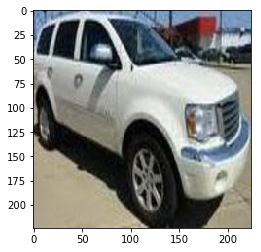

In [44]:
predict(val_iter, endpoint_name)

## Cleaning

In [76]:
!rm -rf $base_dir

In [77]:
%%time
sagemaker_session.delete_endpoint(endpoint_name)

INFO:sagemaker:Deleting endpoint with name: car-classification
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): 169.254.169.254
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): 169.254.169.254
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): sagemaker.us-east-1.amazonaws.com


CPU times: user 20 ms, sys: 8 ms, total: 28 ms
Wall time: 158 ms
